In [1]:
"""Expand and reconstruct any surface
(here a simple box) into spherical harmonics"""
# Expand an arbitrary closed shape in spherical harmonics
# using SHTOOLS (https://shtools.oca.eu/shtools/)
# and then truncate the expansion to a specific lmax and
# reconstruct the projected points in red
import numpy as np
from scipy.interpolate import griddata
import pyshtools
from vedo import spher2cart, mag, Box, Point, Points, show, load

import open3d as o3d

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
###########################################################################
lmax = 8              # maximum degree of the spherical harm. expansion
N    = 50             # number of grid intervals on the unit sphere
rmax = 500        # line length - max distance from cell centre to surface in pixels
###########################################################################

path = '../output/cell_segs_limeseg/Img_1_segmentation1.0/Cell_4701/T_1.ply'

pointcloud = o3d.io.read_point_cloud(path)

x0 = np.array(pointcloud.get_center())
# surface = Box(pos=x0+[10,20,30], size=(300,150,100)).color('grey').alpha(0.2)

surface = load(path).color('grey').alpha(0.2)

############################################################

In [3]:
# cast rays from the sphere center and find intersections
agrid, pts = [], []
for th in np.linspace(0, np.pi, N, endpoint=True):
    longs = []
    for ph in np.linspace(0, 2*np.pi, N, endpoint=False):
        p = spher2cart(rmax, th, ph)
        intersections = surface.intersectWithLine(x0, x0+p)
        if len(intersections):
            value = mag(intersections[0]-x0)
            longs.append(value)
            pts.append(intersections[0])
        else:
            print('No hit for theta, phi =', th, ph)
            longs.append(rmax)
            pts.append(p)
    agrid.append(longs)
agrid = np.array(agrid)

hits = Points(pts).cmap('jet', agrid.ravel()).addScalarBar3D(title='scalar distance to x_0')
show([surface, hits, Point(x0), __doc__], at=0, N=2, axes=1)

#############################################################
grid = pyshtools.SHGrid.from_array(agrid)
clm = grid.expand()
# These must be the components? 
grid_reco = clm.expand(lmax=lmax).to_array()  # cut "high frequency" components

#############################################################
# interpolate to a finer grid
ll = []
for i, long in enumerate(np.linspace(0, 360, num=grid_reco.shape[1], endpoint=False)):
    for j, lat in enumerate(np.linspace(90, -90, num=grid_reco.shape[0], endpoint=True)):
        th = np.deg2rad(90 - lat)
        ph = np.deg2rad(long)
        ll.append((lat, long))

radii = grid_reco.T.ravel()
n = 200j
lnmin, lnmax = np.array(ll).min(axis=0), np.array(ll).max(axis=0)
grid = np.mgrid[lnmax[0]:lnmin[0]:n, lnmin[1]:lnmax[1]:n]
grid_x, grid_y = grid
grid_reco_finer = griddata(ll, radii, (grid_x, grid_y), method='cubic')

pts2 = []
for i, long in enumerate(np.linspace(0, 360, num=grid_reco_finer.shape[1], endpoint=False)):
    for j, lat in enumerate(np.linspace(90, -90, num=grid_reco_finer.shape[0], endpoint=True)):
        th = np.deg2rad(90 - lat)
        ph = np.deg2rad(long)
        p = spher2cart(grid_reco_finer[j][i], th, ph)
        pts2.append(p+x0)

show(f'Spherical harmonics expansion of order {lmax}',
     Points(pts2, c="r", alpha=0.5),
     surface,
     at=1,
).interactive().close()

In [4]:
reconstructed_pointcloud = o3d.geometry.PointCloud()
reconstructed_pointcloud.points = o3d.utility.Vector3dVector(pts2)

In [5]:
dist_pc1_pc2 = reconstructed_pointcloud.compute_point_cloud_distance(pointcloud)

(array([ 1309.,  6350., 11334., 14896.,  5478.,   536.,    42.,    29.,
           16.,    10.]),
 array([ 0.11089282,  1.27529469,  2.43969656,  3.60409844,  4.76850031,
         5.93290219,  7.09730406,  8.26170594,  9.42610781, 10.59050968,
        11.75491156]),
 <BarContainer object of 10 artists>)

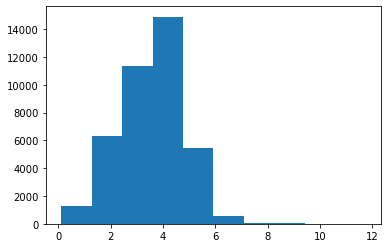

In [6]:
plt.hist(dist_pc1_pc2)

In [7]:
grid = pyshtools.SHGrid.from_array(agrid)
clm = grid.expand()
# These must be the components? 
grid_reco = clm.expand(lmax=lmax).to_array()

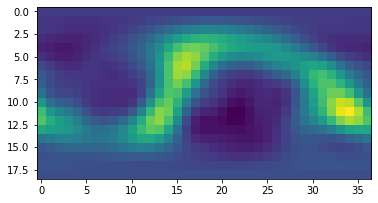

In [8]:
plt.imshow(grid_reco)

In [9]:
pointcloud = o3d.io.read_point_cloud(path)
x0 = np.array(pointcloud.get_center())
x0

array([2291.30678881, 2457.26259496,  349.10936184])

In [10]:
os.listdir('../output/cell_segs_limeseg/Img_1_segmentation2.0/Cell_13474/')

['CellParams.xml', 'T_1.ply', 'T_1.ply_.npy']

In [11]:
path_npy = '../output/cell_segs_limeseg/Img_1_segmentation2.0/Cell_10001/T_1.ply_.npy'
mask = np.load(path_npy, allow_pickle=False)

In [12]:
from skimage.morphology import skeletonize 

skel = skeletonize(mask)

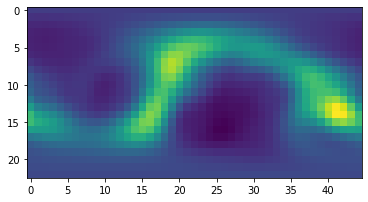

In [13]:
def run_harmonics(path, lmax, N, rmax): 
    pointcloud = o3d.io.read_point_cloud(path)
    if pointcloud.has_points(): 
        x0 = np.array(pointcloud.get_center())
        surface = load(path).color('grey').alpha(0.2)
    else: 
        print(path)
        return [None, None, None]

    agrid, pts = [], []
    for th in np.linspace(0, np.pi, N, endpoint=True):
        longs = []
        for ph in np.linspace(0, 2*np.pi, N, endpoint=False):
            p = spher2cart(rmax, th, ph)
            intersections = surface.intersectWithLine(x0, x0+p)
            if len(intersections):
                value = mag(intersections[0]-x0)
                longs.append(value)
                pts.append(intersections[0])
            else:
                # print('No hit for theta, phi =', th, ph)
                
                longs.append(rmax)
                pts.append(p)
        agrid.append(longs)
    agrid = np.array(agrid)

    #############################################################
    grid = pyshtools.SHGrid.from_array(agrid)
    clm = grid.expand()
    # These must be the components? 
    grid_reco = clm.expand(lmax=lmax).to_array()  # cut "high frequency" components

    #############################################################
    # reconstruct the object 
    ll = []
    for i, long in enumerate(np.linspace(0, 360, num=grid_reco.shape[1], endpoint=False)):
        for j, lat in enumerate(np.linspace(90, -90, num=grid_reco.shape[0], endpoint=True)):
            th = np.deg2rad(90 - lat)
            ph = np.deg2rad(long)
            ll.append((lat, long))

    radii = grid_reco.T.ravel()
    n = 200j
    lnmin, lnmax = np.array(ll).min(axis=0), np.array(ll).max(axis=0)
    grid = np.mgrid[lnmax[0]:lnmin[0]:n, lnmin[1]:lnmax[1]:n]
    grid_x, grid_y = grid
    grid_reco_finer = griddata(ll, radii, (grid_x, grid_y), method='cubic')

    pts2 = []
    for i, long in enumerate(np.linspace(0, 360, num=grid_reco_finer.shape[1], endpoint=False)):
        for j, lat in enumerate(np.linspace(90, -90, num=grid_reco_finer.shape[0], endpoint=True)):
            th = np.deg2rad(90 - lat)
            ph = np.deg2rad(long)
            p = spher2cart(grid_reco_finer[j][i], th, ph)
            pts2.append(p+x0)

    # turn it into a pointcloud 
    reconstructed_pointcloud = o3d.geometry.PointCloud()
    reconstructed_pointcloud.points = o3d.utility.Vector3dVector(pts2)

    # and then get the distance between them! 
    dist_pc1_pc2 = reconstructed_pointcloud.compute_point_cloud_distance(pointcloud)

    return([grid_reco, x0, np.mean(dist_pc1_pc2)])

path = '../output/cell_segs_limeseg/Img_1_segmentation1.0/Cell_4701/T_1.ply'
other, pos, d = run_harmonics(path, lmax = 10, N = 100, rmax = 200)
plt.imshow(other)

In [14]:


# results = pd.read_csv('../limeseg/near_noto_subset_2_out.csv')

# # filter results with a successful mesh 
# # and Euler characteristic of an enclosed object 
# results = results[
#     (results['Mesh ?'] == 'YES') & 
#     (results['Euler characteristic'] == 2)  & 
#     (results['Center Z'] > 40) & 
#     (results['Center Z'] < 100)
#     ]
# anisotropy = 0.25 / 0.0760332 

harmonics_list = []
positions_list = []
quality = []
import os 
cell_list = os.listdir('../output/cell_segs_limeseg/Img_1_segmentation2.0/')

for cell in cell_list: 
    path = '../output/cell_segs_limeseg/Img_1_segmentation2.0/' + cell + '/T_1.ply'
    tmp_out, pos, qual = run_harmonics(path, lmax, N, rmax)
    if tmp_out is not None: # sometimes my function returns None 
        harmonics_list.append(tmp_out)
        positions_list.append(pos)
        quality.append(qual)




[Open3D WARNING] Read PLY failed: number of vertex <= 0.
../output/cell_segs_limeseg/Img_1_segmentation2.0/cell_10000/T_1.ply
[Open3D WARNING] Read PLY failed: number of vertex <= 0.
../output/cell_segs_limeseg/Img_1_segmentation2.0/cell_10002/T_1.ply
[Open3D WARNING] Read PLY failed: number of vertex <= 0.
../output/cell_segs_limeseg/Img_1_segmentation2.0/cell_10003/T_1.ply
[Open3D WARNING] Read PLY failed: number of vertex <= 0.
../output/cell_segs_limeseg/Img_1_segmentation2.0/cell_10004/T_1.ply
[Open3D WARNING] Read PLY failed: number of vertex <= 0.
../output/cell_segs_limeseg/Img_1_segmentation2.0/cell_10015/T_1.ply
[Open3D WARNING] Read PLY failed: number of vertex <= 0.
../output/cell_segs_limeseg/Img_1_segmentation2.0/cell_10017/T_1.ply
[Open3D WARNING] Read PLY failed: number of vertex <= 0.
../output/cell_segs_limeseg/Img_1_segmentation2.0/cell_10020/T_1.ply
[Open3D WARNING] Read PLY failed: number of vertex <= 0.
../output/cell_segs_limeseg/Img_1_segmentation2.0/cell_10021/

In [15]:
quality[0]

4.0549070353342085

(array([3567.,   74.,   28.,    8.,    7.,    8.,    2.,    0.,    2.,
           2.]),
 array([  3.23321288,  26.35966834,  49.48612379,  72.61257925,
         95.73903471, 118.86549017, 141.99194563, 165.11840109,
        188.24485655, 211.37131201, 234.49776747]),
 <BarContainer object of 10 artists>)

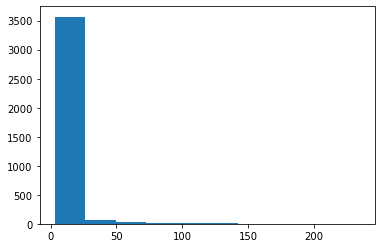

In [16]:
plt.hist(quality)

(array([3114.,  187.,   37.,   20.,   19.,    8.,    8.,    9.,   14.,
          12.]),
 array([3.23321288, 3.90210644, 4.57100001, 5.23989358, 5.90878715,
        6.57768072, 7.24657429, 7.91546785, 8.58436142, 9.25325499,
        9.92214856]),
 <BarContainer object of 10 artists>)

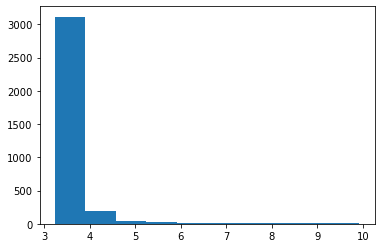

In [17]:
plt.hist([i for i in quality if i < 10])

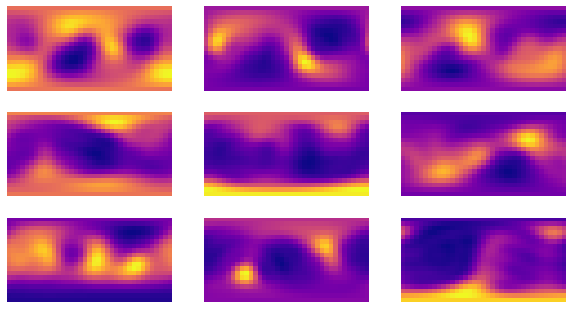

In [18]:
#
import random

fig = plt.figure(figsize = (10, 5.5))

for i in range(9): 
    ax = fig.add_subplot(3, 3, i +1)

    ax.imshow(random.choice(harmonics_list), cmap = 'plasma')
    ax.axis('off')

In [19]:
df = pd.DataFrame([i.flatten() for i in harmonics_list])
df[['X', 'Y', 'Z']] = np.array(positions_list)
df

,0,1,2,3,4,5,6,7,8,9,...,696,697,698,699,700,701,702,X,Y,Z
0,31.195591,31.195591,31.195591,31.195591,31.195591,31.195591,31.195591,31.195591,31.195591,31.195591,...,97.594088,97.594088,97.594088,97.594088,97.594088,97.594088,97.594088,537.567536,584.560851,128.317088
1,50.778281,50.778281,50.778281,50.778281,50.778281,50.778281,50.778281,50.778281,50.778281,50.778281,...,46.531836,46.531836,46.531836,46.531836,46.531836,46.531836,46.531836,464.291260,648.834117,68.851236
2,31.463679,31.463679,31.463679,31.463679,31.463679,31.463679,31.463679,31.463679,31.463679,31.463679,...,25.782457,25.782457,25.782457,25.782457,25.782457,25.782457,25.782457,537.656433,675.444065,101.742525
3,49.876777,49.876777,49.876777,49.876777,49.876777,49.876777,49.876777,49.876777,49.876777,49.876777,...,46.200545,46.200545,46.200545,46.200545,46.200545,46.200545,46.200545,467.080158,694.502321,147.027184
4,81.629020,81.629020,81.629020,81.629020,81.629020,81.629020,81.629020,81.629020,81.629020,81.629020,...,61.912058,61.912058,61.912058,61.912058,61.912058,61.912058,61.912058,634.652295,667.432391,146.897869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,27.945793,27.945793,27.945793,27.945793,27.945793,27.945793,27.945793,27.945793,27.945793,27.945793,...,25.499987,25.499987,25.499987,25.499987,25.499987,25.499987,25.499987,444.036396,688.702215,25.584691
3694,46.575274,46.575274,46.575274,46.575274,46.575274,46.575274,46.575274,46.575274,46.575274,46.575274,...,42.260258,42.260258,42.260258,42.260258,42.260258,42.260258,42.260258,607.307063,793.687854,42.391312
3695,42.611215,42.611215,42.611215,42.611215,42.611215,42.611215,42.611215,42.611215,42.611215,42.611215,...,41.955414,41.955414,41.955414,41.955414,41.955414,41.955414,41.955414,587.829127,659.990567,45.166863
3696,38.464030,38.464030,38.464030,38.464030,38.464030,38.464030,38.464030,38.464030,38.464030,38.464030,...,56.394946,56.394946,56.394946,56.394946,56.394946,56.394946,56.394946,680.677006,664.826834,62.200996


In [86]:
df = pd.DataFrame([i.flatten() for i in harmonics_list])
df[['X', 'Y', 'Z']] = np.array(positions_list)
df['quality'] = quality 
df.to_csv('../output/spherical_harmonics/Embryo1_segmentation2.0.csv')

In [22]:
from skimage.io import imread

In [87]:
tissue_annotation = imread('../data/tissue_segmentations/Experiment-347_s1.ome-1.labels.tif')
df['label'] = tissue_annotation[
    list(round(df['Z']/3.2)), 
    list(df['Y'].astype(int)), 
    list(df['X'].astype(int))
    ] 

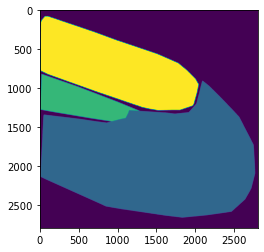

In [79]:
plt.imshow(tissue_annotation[100])

In [88]:

df = df.loc[(df.iloc[:, 0:703] < 200).all(axis=1)] # get rid of silly big values 

df = df[df['quality'] < 5]
df = df[df['label'] != 0]

pca = PCA(0.95)

scaled_data = StandardScaler().fit_transform(df.drop(['X', 'Y', 'Z', 'label'], axis = 1).dropna())


principalComponents = pca.fit_transform(scaled_data)

principalDf = pd.DataFrame(data = principalComponents)

# principalDf['ID'] = list(df['ID'])



Text(0.5, 1.0, 'Blue: anterior. Red: posterior')

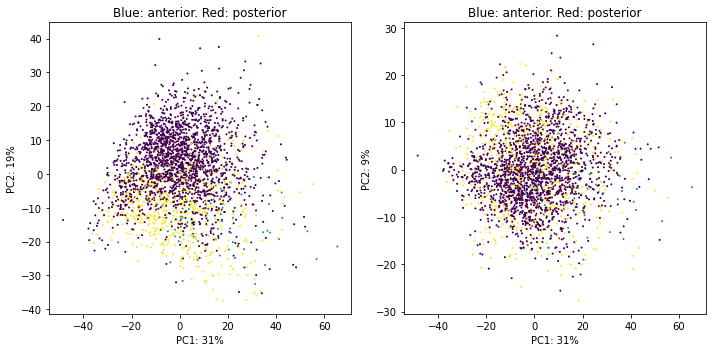

In [89]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5), tight_layout = True)

a, s = 1, 1

ax[0].scatter(
    principalDf.iloc[:, 0], 
    principalDf.iloc[:, 1], 
    c = df['label'], 
    alpha = a, s = s)

ax[0].set_xlabel('PC1: ' + str(round(pca.explained_variance_ratio_[0] * 100)) + '%')
ax[0].set_ylabel('PC2: ' + str(round(pca.explained_variance_ratio_[1] * 100)) + '%')
ax[0].set_title('Blue: anterior. Red: posterior')


ax[1].scatter(
    principalDf.iloc[:, 0], 
    principalDf.iloc[:, 2], 
    alpha = a, s = s, 
    c = df['label'])

ax[1].set_xlabel('PC1: ' + str(round(pca.explained_variance_ratio_[0] * 100)) + '%')
ax[1].set_ylabel('PC2: ' + str(round(pca.explained_variance_ratio_[2] * 100)) + '%')
ax[1].set_title('Blue: anterior. Red: posterior')

In [90]:
import napari 
viewer = napari.Viewer() 

points = df[['Z', 'Y', 'X']]

point_properties = {
    'PC1': principalDf.iloc[:, 0], 
    'PC2': principalDf.iloc[:, 1], 
    'PC3': principalDf.iloc[:, 2], 
    'quality': list(df['quality']/5), 
    'tissue': list(df['label']/3)
}


points_layer = viewer.add_points(
    points,
    properties=point_properties,
    face_color='PC2', 
    face_colormap='viridis', 
    ndim = 3, size=40, 
    edge_width=0,
    out_of_slice_display=True, n_dimensional=3
    
)

points_layer_2 = viewer.add_points(
    points,
    properties=point_properties,
    face_color='PC1', 
    face_colormap='viridis', 
    ndim = 3, size=40, 
    edge_width=0,
    out_of_slice_display=True, 
    n_dimensional=3
    
)

In [91]:
img = imread('../data/nuclei_images/Experiment-347_s1.ome-1.tif')
dapi = viewer.add_image(img, scale = [3.2, 1,1])

In [92]:
viewer.add_image(tissue_annotation,  scale = [3.2, 1,1])

<Image layer 'tissue_annotation' at 0x194e9714c70>

In [93]:
points_layer = viewer.add_points(
    points,
    properties=point_properties,
    face_color='tissue', 
    face_colormap='viridis', 
    ndim = 3, size=40, 
    edge_width=0,
    out_of_slice_display=True, n_dimensional=3
    
)

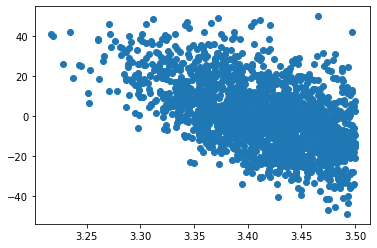

In [ ]:
plt.scatter(df['quality'],  principalDf.iloc[:, 0])

Text(0.5, 1.0, 'Explained variance')

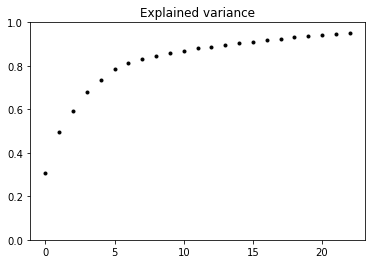

In [57]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), '.', c = 'k')
plt.ylim(0, 1)

plt.title('Explained variance')

In [ ]:
# cast rays from the sphere center and find intersections
agrid, pts = [], []
for th in np.linspace(0, np.pi, N, endpoint=True):
    longs = []
    for ph in np.linspace(0, 2*np.pi, N, endpoint=False):
        p = spher2cart(rmax, th, ph)
        intersections = surface.intersectWithLine(x0, x0+p)
        if len(intersections):
            value = mag(intersections[0]-x0)
            longs.append(value)
            pts.append(intersections[0])
        else:
            print('No hit for theta, phi =', th, ph)
            longs.append(rmax)
            pts.append(p)
    agrid.append(longs)
agrid = np.array(agrid)

hits = Points(pts).cmap('jet', agrid.ravel()).addScalarBar3D(title='scalar distance to x_0')
show([surface, hits, Point(x0), __doc__], at=0, N=2, axes=1)

#############################################################
grid = pyshtools.SHGrid.from_array(agrid)
clm = grid.expand()
# These must be the components? 
grid_reco = clm.expand(lmax=lmax).to_array()  # cut "high frequency" components

#############################################################
# interpolate to a finer grid
ll = []
for i, long in enumerate(np.linspace(0, 360, num=grid_reco.shape[1], endpoint=False)):
    for j, lat in enumerate(np.linspace(90, -90, num=grid_reco.shape[0], endpoint=True)):
        th = np.deg2rad(90 - lat)
        ph = np.deg2rad(long)
        ll.append((lat, long))

radii = grid_reco.T.ravel()
n = 200j
lnmin, lnmax = np.array(ll).min(axis=0), np.array(ll).max(axis=0)
grid = np.mgrid[lnmax[0]:lnmin[0]:n, lnmin[1]:lnmax[1]:n]
grid_x, grid_y = grid
grid_reco_finer = griddata(ll, radii, (grid_x, grid_y), method='cubic')

pts2 = []
for i, long in enumerate(np.linspace(0, 360, num=grid_reco_finer.shape[1], endpoint=False)):
    for j, lat in enumerate(np.linspace(90, -90, num=grid_reco_finer.shape[0], endpoint=True)):
        th = np.deg2rad(90 - lat)
        ph = np.deg2rad(long)
        p = spher2cart(grid_reco_finer[j][i], th, ph)
        pts2.append(p+x0)

show(f'Spherical harmonics expansion of order {lmax}',
     Points(pts2, c="r", alpha=0.5),
     surface,
     at=1,
).interactive().close()

Error: Canceled future for execute_request message before replies were done

In [ ]:
print(grid_reco.shape)

(11, 21)
